# **1. Data limitation**
---
---
Restricción de carga de datos a la media de la cantidad de las emociones del set de entrenamiento

## **Carga de datos**

In [45]:
import pandas as pd

df = pd.read_csv("full_multilabel_df.csv")
df.fillna(0, inplace=True)

In [46]:
index_out = df[df['database'] == 'ESC'].index.tolist()
# Drop indices from DataFrame
df.drop(index_out, inplace=True)
df.reset_index(drop=True, inplace=True)

In [47]:
df['database'].value_counts()

database
INTER1SP    6041
SMC         5129
EMS         2005
EW          1992
MESD         862
EmoFilm      359
Name: count, dtype: int64

In [48]:
import numpy as np

features = np.load("full_multilabel_w2v2_53es_layer6.npz")
features = list(features.values())

In [49]:
# Remove corresponding indices from features
features = np.delete(features, index_out, axis=0)

In [50]:
# Verify alignment
assert len(df) == features.shape[0], "Mismatch between df and features length"

## **Preparación de datos**

### Separación de datos

In [51]:
from sklearn.model_selection import train_test_split
import numpy as np

# Dividir en train y test con estratificación por emoción
df_train, df_test = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    shuffle=True, 
    stratify=df['new_emotion']
)


### Limitación de emociones

In [52]:
import pandas as pd

# Contar cuántas muestras hay por emoción
emotion_counts = df_train["new_emotion"].value_counts()

# Obtener la emoción mediana (por cantidad de ocurrencias)
median_emotion = emotion_counts.sort_values().index[len(emotion_counts) // 2]
print("Mediana de emociones:", median_emotion, emotion_counts.median())


Mediana de emociones: happiness 1528.0


In [53]:
target_per_class = emotion_counts.median()

# 2. Submuestreo por clase, priorizando audios largos, conservando índices
selected_indices = []

for emotion, group in df_train.groupby("new_emotion"):
    # Ordenar por duración descendente
    sorted_group = group.sort_values(by="duration", ascending=False)

    # Seleccionar los índices a conservar
    if len(group) > target_per_class:
        keep_indices = sorted_group.index[:int(target_per_class)]
    else:
        keep_indices = sorted_group.index

    selected_indices.extend(keep_indices)

# 3. Crear el DataFrame balanceado con los índices seleccionados
balanced_df_train = df_train.loc[selected_indices].copy()

In [54]:
balanced_df_train['new_emotion'].value_counts()

new_emotion
anger        1528
disgust      1528
happiness    1528
neutral      1528
sadness      1490
fear         1446
surprise      820
Name: count, dtype: int64

In [55]:
balanced_df_train['new_emotion']

11485       anger
8619        anger
8601        anger
11394       anger
8533        anger
           ...   
10642    surprise
10651    surprise
10623    surprise
10662    surprise
10673    surprise
Name: new_emotion, Length: 9868, dtype: object

In [56]:
balanced_df_train['new_emotion'].to_csv("train_undersampling_1528.csv", index=False)

### **Añadir tipo de muestra (actuada o natural)**

In [57]:
e_dbs = ['SMC', 'EMS', 'INTER1SP', 'EmoFilm']
m_dbs = ['EmoWisconsin', 'MESD', ]

balanced_df_train['accent'] = balanced_df_train['database'].apply(lambda x: 'spain' if x in e_dbs else 'mex')
df_test['accent'] = df_test['database'].apply(lambda x: 'spain' if x in e_dbs else 'mex')

In [58]:
# Codificar emociones y género como variables dummy (0/1)
y_emotion = pd.get_dummies(balanced_df_train["new_emotion"])  # columnas: positive, neutral, negative
y_gender = pd.get_dummies(balanced_df_train["gender"])        # columnas: female, male, child
y_accent = pd.get_dummies(balanced_df_train["accent"]) 

# Unir ambos en una sola matriz de salida
y_train = pd.concat([y_gender, y_accent, y_emotion], axis=1).values


In [59]:
# Codificar emociones y género como variables dummy (0/1)
y_emotion = pd.get_dummies(df_test["new_emotion"])  # columnas: positive, neutral, negative
y_gender = pd.get_dummies(df_test["gender"])        # columnas: female, male, child
y_accent = pd.get_dummies(df_test["accent"]) 

# Unir ambos en una sola matriz de salida
y_test = pd.concat([y_gender, y_accent, y_emotion], axis=1).values


In [60]:
assert (df_test.index.isin(balanced_df_train.index) == False).all()

In [61]:
X_train = features[balanced_df_train.index]
X_test = features[df_test.index]

In [62]:
from sklearn.preprocessing import StandardScaler

# Escalado de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Convierte explícitamente las etiquetas
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [63]:
X_train.shape, y_train.shape

((9868, 1024), (9868, 12))

## **Entrenamiento**
1. Grid-Search Cross-validation Multioutput
2. Basado en Macro-F1
3. Entrenamiento en Chain


In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# Escalado de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Definición del modelo base ---
base_mlp = MLPClassifier(max_iter=500, random_state=42)

# --- Búsqueda de hiperparámetros ---
param_grid = {
    'estimator__hidden_layer_sizes': [(512, 256, 256), (512, 512, 256), (512, 512, 512, 256)],
    'estimator__activation': ['relu'],
    'estimator__learning_rate_init': [0.001, 0.0005, 0.0001],
    'estimator__alpha': [0.0001, 0.001],
}

# --- Clasificador multietiqueta ---
multioutput = MultiOutputClassifier(base_mlp)

# --- Métrica de evaluación (F1 macro promedio sobre etiquetas) ---
f1_weighted_scorer = make_scorer(f1_score, average='weighted')

# --- GridSearchCV ---
grid_search = GridSearchCV(
    estimator=multioutput,
    param_grid=param_grid,
    scoring=f1_weighted_scorer,
    cv=3,
    verbose=3,
    n_jobs=-1  # paraleliza en todos los cores disponibles
)

In [44]:
# --- Entrenamiento ---
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\model_selection\_search.py:412: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(param_list)


GridSearchCV(cv=3,
             estimator=MultiOutputClassifier(estimator=MLPClassifier(max_iter=500,
                                                                     random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__activation': ['relu'],
                         'estimator__alpha': [0.0001, 0.001],
                         'estimator__hidden_layer_sizes': [(512, 256, 256),
                                                           (512, 512, 256),
                                                           (512, 512, 512,
                                                            256)],
                         'estimator__learning_rate_init': [0.001, 0.0005,
                                                           0.0001]},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted),
             verbose=3)

In [45]:
from sklearn.metrics import classification_report, accuracy_score, hamming_loss

# --- Resultados ---
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

print("\nF1-score (weighted) en el set de prueba:")
y_pred = grid_search.best_estimator_.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))

# ====================================
# 5. Reportes separados: Emociones y Género
# ====================================

# Separar emociones (columnas 0-6) y género (columnas 7-9)
y_test_gender = y_test[:, :3]
y_test_accent = y_test[:, 3:5]
y_test_emotions = y_test[:, 5:]

y_pred_gender = y_pred[:, :3]
y_pred_accent = y_pred[:, 3:5]
y_pred_emotions = y_pred[:, 5:]

emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
gender_labels = ['female', 'male', 'child']
accent_labels = ['mex', 'spain']

# ======= Reporte Emociones ========
print("\n===== Reporte de EMOCIONES =====")

print("\nClassification Report (Emociones):")
print(classification_report(y_test_emotions, y_pred_emotions, target_names=emotion_labels, digits=6))

print("Accuracy (Emociones):", accuracy_score(y_test_emotions, y_pred_emotions))
print("Hamming Loss (Emociones):", hamming_loss(y_test_emotions, y_pred_emotions))
print("F1 weighted (Emociones):", f1_score(y_test_emotions, y_pred_emotions, average="weighted"))

# ======= Reporte Género ========a
print("\n===== Reporte de GÉNERO =====")

print("\nClassification Report (Género):")
print(classification_report(y_test_gender, y_pred_gender, target_names=gender_labels, digits=6))

print("Accuracy (Género):", accuracy_score(y_test_gender, y_pred_gender))
print("Hamming Loss (Género):", hamming_loss(y_test_gender, y_pred_gender))
print("F1 weighted (Género):", f1_score(y_test_gender, y_pred_gender, average="weighted"))

# ======= Reporte tipo ========a
print("\n===== Reporte de TIPO =====")

print("\nClassification Report (Acento):")
print(classification_report(y_test_accent, y_pred_accent, target_names=accent_labels, digits=6))

print("Accuracy (Género):", accuracy_score(y_test_accent, y_pred_accent))
print("Hamming Loss (Género):", hamming_loss(y_test_accent, y_pred_accent))
print("F1 weighted (Género):", f1_score(y_test_accent, y_pred_accent, average="weighted"))

Mejores hiperparámetros encontrados:
{'estimator__activation': 'relu', 'estimator__alpha': 0.001, 'estimator__hidden_layer_sizes': (512, 512, 256), 'estimator__learning_rate_init': 0.001}

F1-score (weighted) en el set de prueba:
0.9119245322448875

===== Reporte de EMOCIONES =====

Classification Report (Emociones):
              precision    recall  f1-score   support

       anger   0.756098  0.878866  0.812872       388
     disgust   0.874092  0.796909  0.833718       453
        fear   0.582192  0.941828  0.719577       361
   happiness   0.748869  0.866492  0.803398       382
     neutral   0.974257  0.440860  0.607033      1116
     sadness   0.755507  0.919571  0.829504       373
    surprise   0.877828  0.946341  0.910798       205

   micro avg   0.782410  0.732764  0.756774      3278
   macro avg   0.795549  0.827267  0.788129      3278
weighted avg   0.834228  0.732764  0.742313      3278
 samples avg   0.719239  0.732764  0.723714      3278

Accuracy (Emociones): 0.705918

c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [20]:
from sklearn.metrics import hamming_loss, accuracy_score

# Hamming Loss: porcentaje de etiquetas mal clasificadas (por etiqueta)
hl = hamming_loss(y_test, y_pred)
print(f"Hamming Loss: {hl:.4f}")

# Exact Match Ratio (Subset Accuracy): solo acierta si TODAS las etiquetas coinciden
emr = accuracy_score(y_test, y_pred)
print(f"Exact Match Ratio: {emr:.4f}")


Hamming Loss: 0.1169
Exact Match Ratio: 0.2870


## **Entrenamiento Chain**
{'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (512, 256, 256), 'estimator__learning_rate_init': 0.001}


In [43]:
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, f1_score

mlp = MLPClassifier(
    activation='relu',
    alpha=0.0001,
    hidden_layer_sizes=(512, 256, 256),
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42,
)



mlp.fit(X_train, y_train)


MLPClassifier(hidden_layer_sizes=(512, 256, 256), max_iter=1000,
              random_state=42)

In [44]:
from sklearn.metrics import classification_report, accuracy_score, hamming_loss

print("\nF1-score (weighted) en el set de prueba:")
y_pred = mlp.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))

# ====================================
# 5. Reportes separados: Emociones y Género
# ====================================

# Separar emociones (columnas 0-6) y género (columnas 7-9)
y_test_gender = y_test[:, :3]
y_test_accent = y_test[:, 3:5]
y_test_emotions = y_test[:, 5:]

y_pred_gender = y_pred[:, :3]
y_pred_accent = y_pred[:, 3:5]
y_pred_emotions = y_pred[:, 5:]

emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
gender_labels = ['female', 'male', 'child']
accent_labels = ['mex', 'spain']

# ======= Reporte Emociones ========
print("\n===== Reporte de EMOCIONES =====")

print("\nClassification Report (Emociones):")
print(classification_report(y_test_emotions, y_pred_emotions, target_names=emotion_labels, digits=6))

print("Accuracy (Emociones):", accuracy_score(y_test_emotions, y_pred_emotions))
print("Hamming Loss (Emociones):", hamming_loss(y_test_emotions, y_pred_emotions))
print("F1 weighted (Emociones):", f1_score(y_test_emotions, y_pred_emotions, average="weighted"))

# ======= Reporte Género ========a
print("\n===== Reporte de GÉNERO =====")

print("\nClassification Report (Género):")
print(classification_report(y_test_gender, y_pred_gender, target_names=gender_labels,  digits=6))

print("Accuracy (Género):", accuracy_score(y_test_gender, y_pred_gender))
print("Hamming Loss (Género):", hamming_loss(y_test_gender, y_pred_gender))
print("F1 weighted (Género):", f1_score(y_test_gender, y_pred_gender, average="weighted"))

# ======= Reporte tipo ========a
print("\n===== Reporte de TIPO =====")

print("\nClassification Report (Acento):")
print(classification_report(y_test_accent, y_pred_accent, target_names=accent_labels, digits=6))

print("Accuracy (Género):", accuracy_score(y_test_accent, y_pred_accent))
print("Hamming Loss (Género):", hamming_loss(y_test_accent, y_pred_accent))
print("F1 weighted (Género):", f1_score(y_test_accent, y_pred_accent, average="weighted"))


F1-score (weighted) en el set de prueba:
0.9179350854064057

===== Reporte de EMOCIONES =====

Classification Report (Emociones):
              precision    recall  f1-score   support

       anger   0.831202  0.837629  0.834403       388
     disgust   0.877934  0.825607  0.850967       453
        fear   0.609155  0.958449  0.744887       361
   happiness   0.755149  0.863874  0.805861       382
     neutral   0.961806  0.496416  0.654846      1116
     sadness   0.685149  0.927614  0.788155       373
    surprise   0.872146  0.931707  0.900943       205

   micro avg   0.789878  0.752288  0.770625      3278
   macro avg   0.798934  0.834471  0.797152      3278
weighted avg   0.834749  0.752288  0.761276      3278
 samples avg   0.748627  0.752288  0.749847      3278

Accuracy (Emociones): 0.7449664429530202
Hamming Loss (Emociones): 0.06397629216421162
F1 weighted (Emociones): 0.7612761316404969

===== Reporte de GÉNERO =====

Classification Report (Género):
              precision

c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AlxMa\.conda\envs\datascience\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **Gráficas**

In [46]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Separar las predicciones ---
n_emotions = y_emotion.shape[1]
n_gender = y_gender.shape[1]
n_accent = y_accent.shape[1]

# --- Obtener etiquetas predichas y verdaderas ---
gender_true = np.argmax(y_test[:, :n_gender], axis=1)
gender_pred = np.argmax(y_pred[:, :n_gender], axis=1)

accent_true = np.argmax(y_test[:, n_gender:n_gender + n_accent], axis=1)
accent_pred = np.argmax(y_pred[:, n_gender:n_gender + n_accent], axis=1)

emotion_true = np.argmax(y_test[:, n_gender + n_accent:], axis=1)
emotion_pred = np.argmax(y_pred[:, n_gender + n_accent:], axis=1)

emotion_labels = y_emotion.columns.tolist()
gender_labels = ['child', 'female', 'male']
accent_labels = y_accent.columns.tolist()

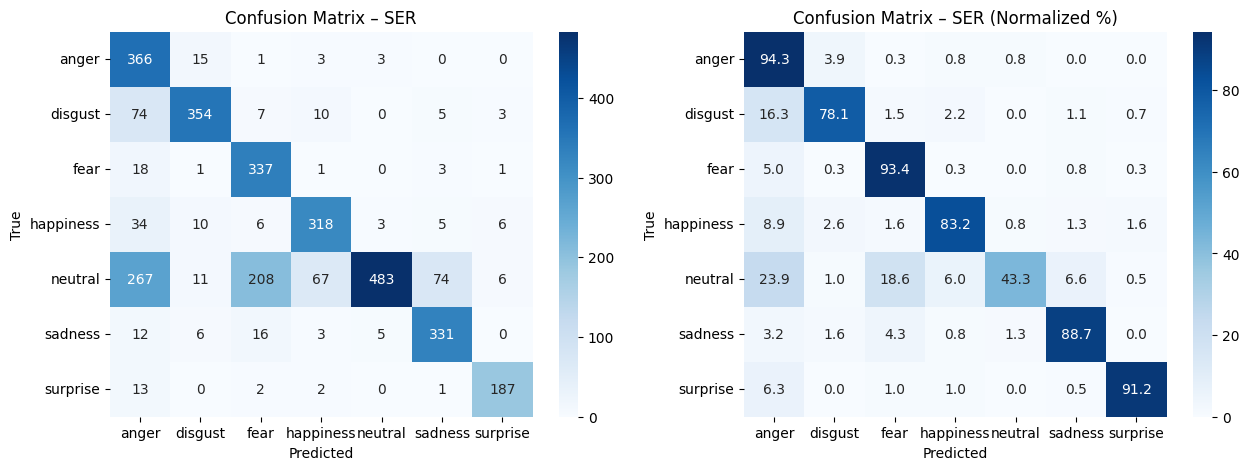

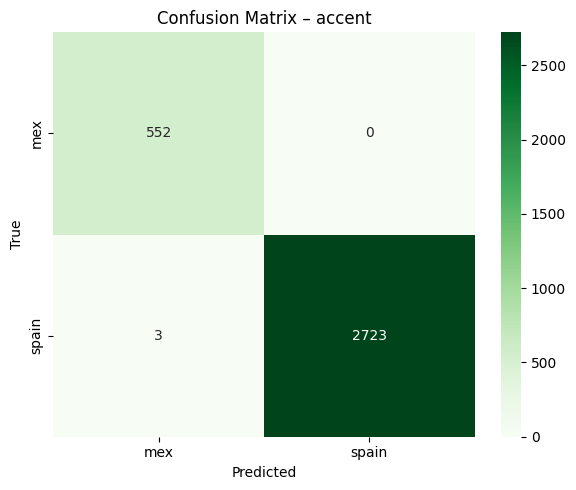

In [47]:
# --- Heatmap para emociones ---
#--------------------------------------------------
#--------------------------------------------------
#--------------------------------------------------
cm_emotion = confusion_matrix(emotion_true, emotion_pred, labels=range(len(emotion_labels)))
cm_emotion_norm = cm_emotion.astype('float') / cm_emotion.sum(axis=1, keepdims=True)


# Crear figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(cm_emotion, annot=True, fmt='d', 
            xticklabels=emotion_labels, yticklabels=emotion_labels, 
            cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix – SER")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_emotion_norm * 100, annot=True, fmt='.1f',
            xticklabels=emotion_labels, yticklabels=emotion_labels, 
            cmap='Blues', ax=axes[1])
axes[1].set_title("Confusion Matrix – SER (Normalized %)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")




# --- Heatmap para género ---
cm_accent = confusion_matrix(accent_true, accent_pred, labels=range(len(accent_labels)))
cm_accent_norm = cm_accent.astype('float') / cm_accent.sum(axis=1, keepdims=True)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_accent, annot=True, fmt='d', xticklabels=accent_labels, yticklabels=accent_labels, cmap='Greens')
plt.title("Confusion Matrix – accent")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


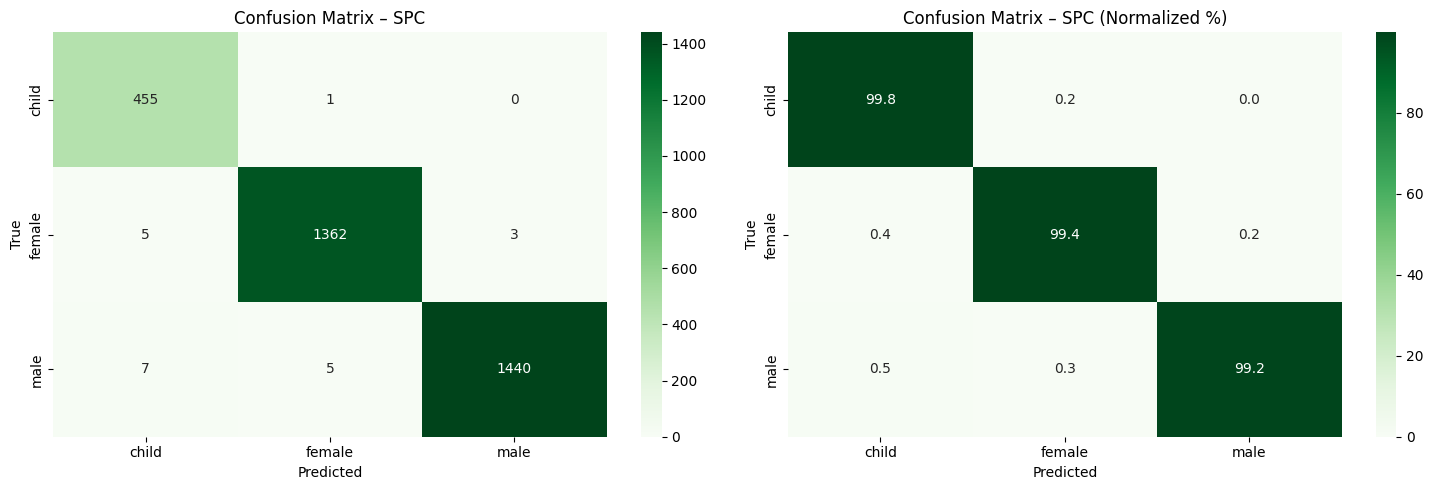

In [48]:
# --- Heatmap para género ---
#--------------------------------------------------
#--------------------------------------------------
#--------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
cm_gender = confusion_matrix(gender_true, gender_pred, labels=range(len(gender_labels)))
cm_gender_norm = cm_gender.astype('float') / cm_gender.sum(axis=1, keepdims=True)

sns.heatmap(cm_gender, annot=True, fmt='d', 
            xticklabels=gender_labels, yticklabels=gender_labels, 
            cmap='Greens', ax=axes[0])
axes[0].set_title("Confusion Matrix – SPC")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_gender_norm * 100, annot=True, fmt='.1f',
            xticklabels=gender_labels, yticklabels=gender_labels, 
            cmap='Greens', ax=axes[1])
axes[1].set_title("Confusion Matrix – SPC (Normalized %)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

# Estilo general
plt.tight_layout()
plt.show()

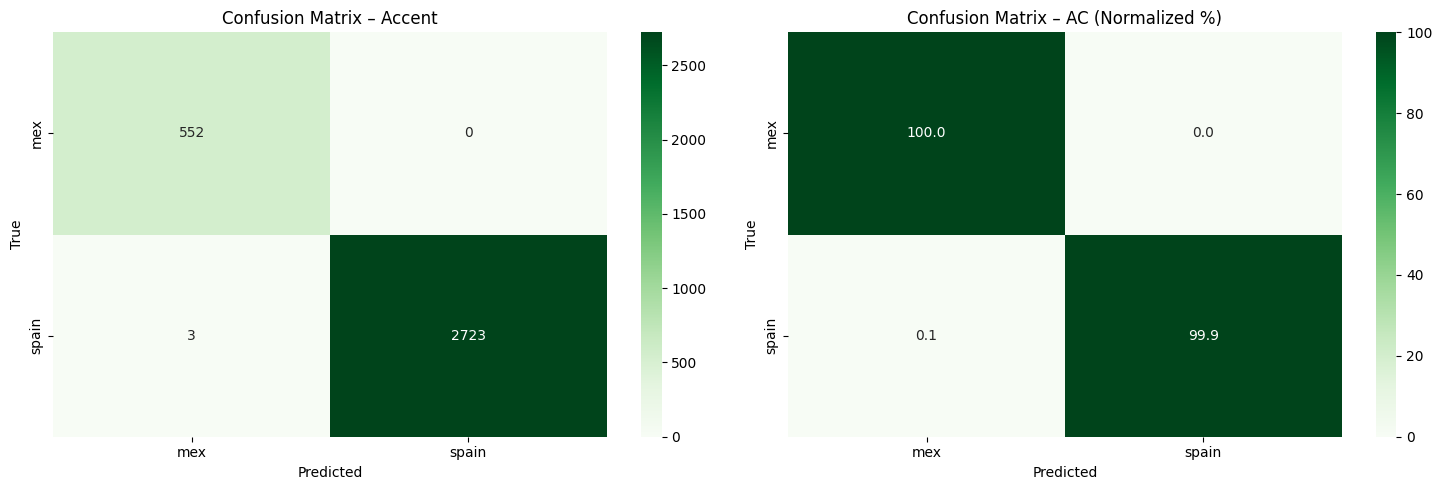

In [49]:
# --- Heatmap para acento ---
#--------------------------------------------------
#--------------------------------------------------
#--------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
cm_accent = confusion_matrix(accent_true, accent_pred, labels=range(len(accent_labels)))
cm_accent_norm = cm_accent.astype('float') / cm_accent.sum(axis=1, keepdims=True)

sns.heatmap(cm_accent, annot=True, fmt='d', 
            xticklabels=accent_labels, yticklabels=accent_labels, 
            cmap='Greens', ax=axes[0])
axes[0].set_title("Confusion Matrix – Accent")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_accent_norm * 100, annot=True, fmt='.1f',
            xticklabels=accent_labels, yticklabels=accent_labels, 
            cmap='Greens', ax=axes[1])
axes[1].set_title("Confusion Matrix – AC (Normalized %)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

# Estilo general
plt.tight_layout()
plt.show()

C:\Users\AlxMa\AppData\Local\Temp\ipykernel_12716\4101380246.py:24: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
C:\Users\AlxMa\AppData\Local\Temp\ipykernel_12716\4101380246.py:24: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
C:\Users\AlxMa\AppData\Local\Temp\ipykernel_12716\4101380246.py:24: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
C:\Users\AlxMa\AppData\Local\Temp\ipykernel_12716\4101380246.py:24: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)


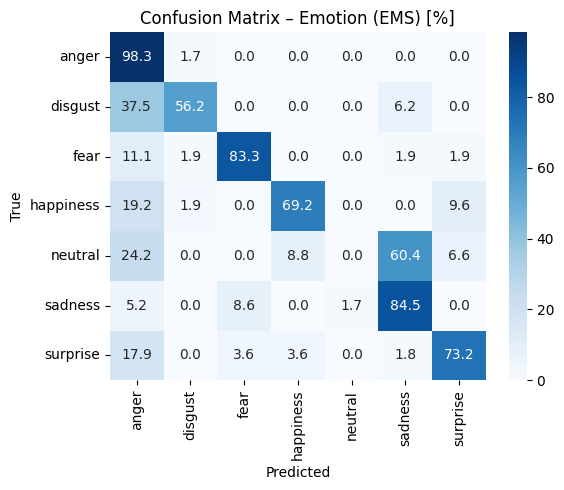

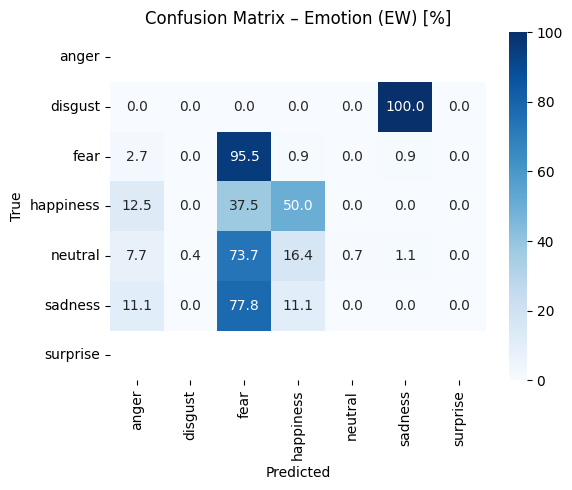

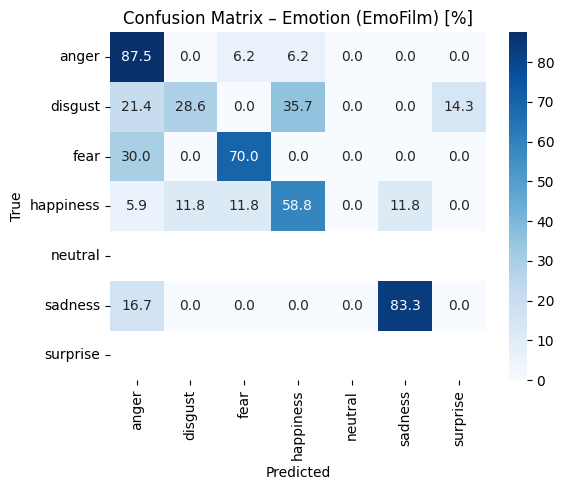

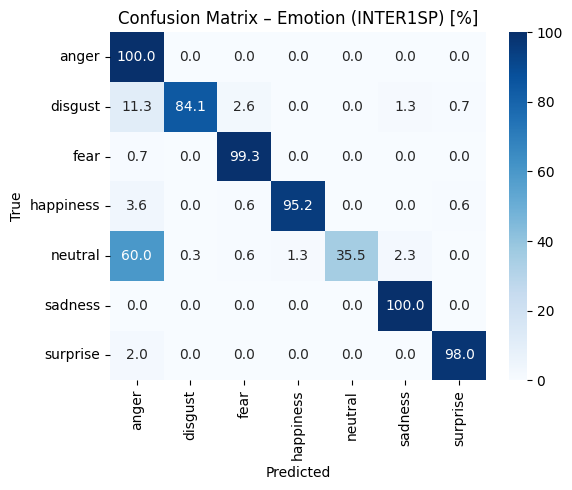

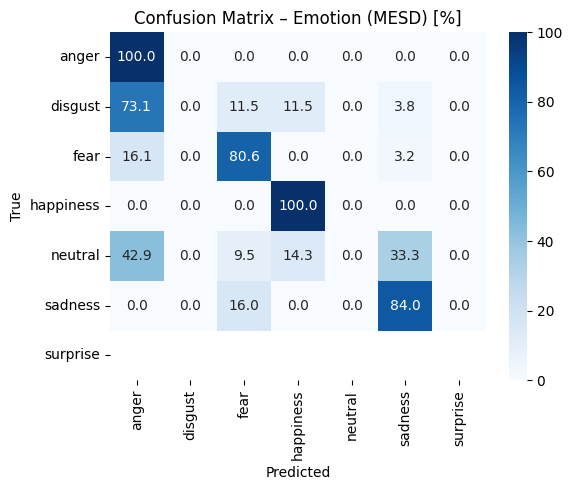

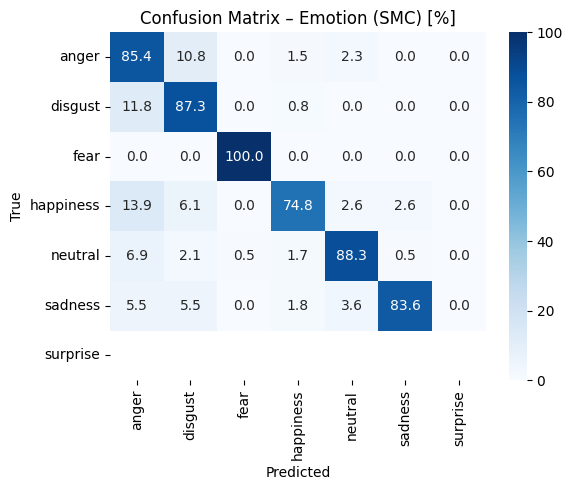

In [51]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Base de datos correspondiente a cada muestra
databases = df_test['database']


# Diccionario para almacenar los heatmaps por base
conf_matrices = {}

for db in np.unique(databases):
    mask = databases == db
    
    # Filtrar por base
    emo_t = emotion_true[mask]
    emo_p = emotion_pred[mask]
    
    # Matriz bruta
    cm = confusion_matrix(emo_t, emo_p, labels=range(len(emotion_labels)))
    
    # Normalizar por filas (por clase real)
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    
    # Guardar
    conf_matrices[db] = cm_norm

for db in np.unique(databases):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrices[db] * 100, annot=True, fmt='.1f',
                xticklabels=emotion_labels, yticklabels=emotion_labels, cmap='Blues')
    plt.title(f"Confusion Matrix – Emotion ({db}) [%]")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    cm_emotion

---
---
# **Guardar resultados**

In [52]:
results = pd.DataFrame()

results[[l + '_test' for l in emotion_labels]] = y_test_emotions
results[[l + '_pred' for l in emotion_labels]] = y_pred_emotions

results[[l + '_test' for l in gender_labels]] = y_test_gender
results[[l + '_pred' for l in gender_labels]] = y_pred_gender

results[[l + '_test' for l in accent_labels]] = y_test_accent
results[[l + '_pred' for l in accent_labels]] = y_pred_accent

results.to_csv("preds_multioutput_limitation.csv")
results

,anger_test,disgust_test,fear_test,happiness_test,neutral_test,sadness_test,surprise_test,anger_pred,disgust_pred,fear_pred,...,child_test,female_test,male_test,child_pred,female_pred,male_pred,mex_test,spain_test,mex_pred,spain_pred
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3273,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3274,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3275,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3276,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
